In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import XGBModel, LinearRegressionModel, StatsForecastAutoARIMA

In [2]:
# Read and process the dataframes
df = pd.read_csv('cases_1to4wk.csv').drop('Unnamed: 0', axis=1)
df = df.rename({'forecast_0.1' : 'cases_forecast_0.1', 'forecast_0.9' : 'cases_forecast_0.9', 'actual' : 'actual_cases'}, axis=1)

In [3]:
df['score_upper'] =  (df['actual_cases'] - df['cases_forecast_0.9'])
df['score_lower'] =  (df['cases_forecast_0.1'] - df['actual_cases'])

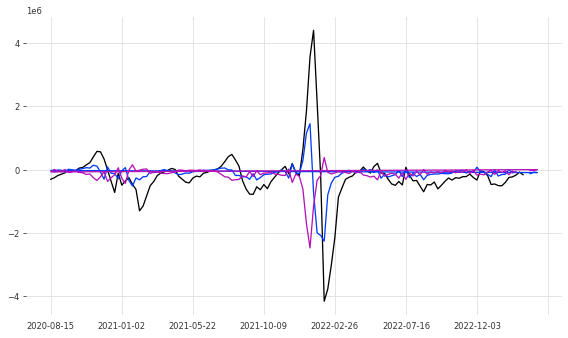

In [4]:
# Plot score functions
plt.figure(figsize=(8,4.8))
plt.plot(df[df.ahead == 4].target_end_date, df[df.ahead == 4].score_upper)
plt.plot(df[df.ahead == 1].target_end_date, df[df.ahead == 1].score_upper)
plt.plot(df[df.ahead == 1].target_end_date, df[df.ahead == 1].score_lower)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
#plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
plt.tight_layout()

In [5]:
# Create TimeSeries objects
scores_upper_3wk = TimeSeries.from_dataframe(df[df.ahead == 3], time_col='target_end_date', value_cols='score_upper')
scores_lower_3wk = TimeSeries.from_dataframe(df[df.ahead == 3], time_col='target_end_date', value_cols='score_lower')
scores_upper_1wk = TimeSeries.from_dataframe(df[df.ahead == 1], time_col='target_end_date', value_cols='score_upper')
scores_lower_1wk = TimeSeries.from_dataframe(df[df.ahead == 1], time_col='target_end_date', value_cols='score_lower')
scores_upper_2wk = TimeSeries.from_dataframe(df[df.ahead == 2], time_col='target_end_date', value_cols='score_upper')
scores_lower_2wk = TimeSeries.from_dataframe(df[df.ahead == 2], time_col='target_end_date', value_cols='score_lower')
cases = TimeSeries.from_dataframe(df[df.ahead == 3], time_col='target_end_date', value_cols='actual_cases')
forecast_upper_3wk = TimeSeries.from_dataframe(df[df.ahead == 3], time_col='target_end_date', value_cols='cases_forecast_0.9')
forecast_lower_3wk = TimeSeries.from_dataframe(df[df.ahead == 3], time_col='target_end_date', value_cols='cases_forecast_0.1')
                                      
model = XGBModel(lags=[-3, -4, -5], lags_past_covariates=1, quantiles=0.90)

# Perform the backtesting
past_covariates = [forecast_upper_3wk, forecast_lower_3wk, cases.shift(3), scores_upper_1wk.shift(3), scores_lower_1wk.shift(3), scores_upper_2wk.shift(2), scores_lower_2wk.shift(2)]
scorecasts = model.historical_forecasts([scores_lower_3wk, scores_upper_3wk], past_covariates = past_covariates)

In [27]:
model_lower = XGBModel(lags=[-3, -4, -5], lags_past_covariates=None, quantiles=0.90)
# Perform the backtesting
past_covariates = None#[ scores_lower_2wk.shift(2)]
scorecasts_lower = model_lower.historical_forecasts(scores_lower_3wk, past_covariates = past_covariates)

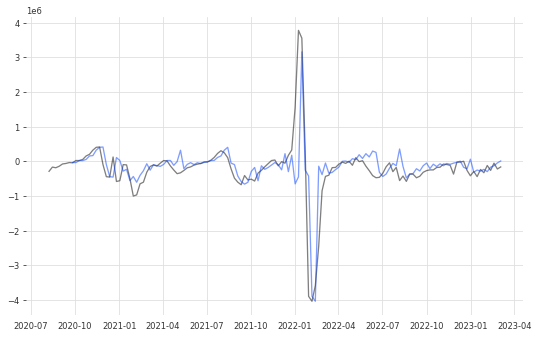

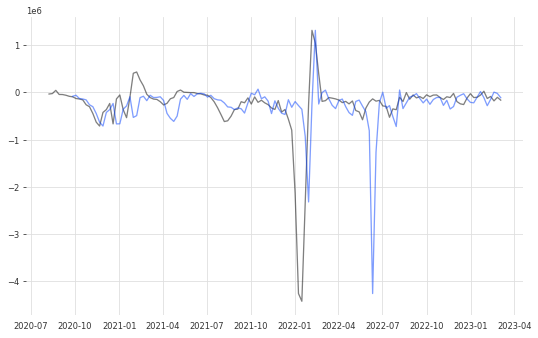

In [28]:
plt.figure(figsize=(7.6,4.8))
plt.plot(np.array(scores_upper_3wk.time_index), scores_upper_3wk.values(), alpha=0.5)
plt.plot(np.array(scorecasts[1].time_index), scorecasts[1].values(), alpha=0.5)
plt.tight_layout()

plt.figure(figsize=(7.6,4.8))
plt.plot(np.array(scores_lower_3wk.time_index), scores_lower_3wk.values(), alpha=0.5)
plt.plot(np.array(scorecasts_lower.time_index), scorecasts_lower.values(), alpha=0.5)
plt.tight_layout()

In [19]:
scorecasts[1].pd_dataframe()

component,score_upper
time,
2020-09-26,-33952.996094
2020-10-03,-33952.996094
2020-10-10,25949.994141
2020-10-17,23281.000000
2020-10-24,55904.960938
...,...
2023-02-04,-295635.062500
2023-02-11,-166906.468750
2023-02-18,-127748.937500


In [20]:
# Create a dataset for use with the base framework
dataset = scores_upper_3wk.pd_dataframe().merge(
    scores_lower_3wk.pd_dataframe(), on='target_end_date').merge(
    scorecasts[0].pd_dataframe().rename_axis(index={"time" : "target_end_date"}).rename({"score_lower" : "scorecast_lower"}, axis=1), on='target_end_date').merge(
    scorecasts[1].pd_dataframe().rename_axis(index={"time" : "target_end_date"}).rename({"score_upper" : "scorecast_upper"}, axis=1), on='target_end_date').astype(float)
df.target_end_date = pd.to_datetime(df.target_end_date)
dataset = dataset.merge(df[df.ahead == 3].drop(['ahead', 'score_upper', 'score_lower'], axis=1), on='target_end_date')

dataset['scores'] = [np.array([dataset['score_lower'][j], dataset['score_upper'][j]]) for j in range(len(dataset))]
dataset['scorecasts'] = [np.array([dataset['scorecast_lower'][j], dataset['scorecast_upper'][j]]) for j in range(len(dataset))]
dataset['forecasts'] = [np.array([dataset['cases_forecast_0.1'][j], dataset['cases_forecast_0.9'][j]]) for j in range(len(dataset))]
dataset = dataset.drop(['score_lower', 'score_upper', 'scorecast_lower', 'scorecast_upper', 'cases_forecast_0.1', 'cases_forecast_0.9', 'forecast_date'], axis=1).rename({'target_end_date' : 'timestamp', 'actual_cases' : 'y'}, axis=1).melt(id_vars=['timestamp'], value_name='target')

In [9]:
dataset.to_pickle('./proc_3wkcases.pkl')